In [38]:
%matplotlib inline
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from PIL import Image, ImageFilter
from scipy.ndimage.filters import gaussian_filter
from skimage.filters import *
from skimage.transform import *
import os
import math
from math import floor

In [39]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [40]:
def PS(T, r):
    T = np.transpose(T, (1, 2, 0))
    rW = r*len(T)
    rH = r*len(T[0])
    C = len(T[0][0])/(r*r)

    # make sure C is an integer and cast if this is the case
    assert(C == int(C))
    C = int(C)
    
    res = np.zeros((rW, rH, C))

    for x in range(len(res)):
        for y in range(len(res[x])):
            for c in range(len(res[x][y])):
                res[x][y][c] = \
                    T[x // r][y // r][C*r*(y % r) + C*(x % r) + c]
    return res

def PS_inv(img, r):
    r2 = r*r
    W = len(img)/r
    H = len(img[0])/r
    C = len(img[0][0])
    Cr2 = C*r2

    # Make sure H and W are integers
    assert(int(H) == H and int(W) == W)
    H, W = int(H), int(W)

    res = np.zeros((W, H, Cr2))

    for x in range(len(img)):
        for y in range(len(img[x])):
            for c in range(len(img[x][y])):
                res[x // r][y // r][C*r*(y % r) + C*(x % r) + c] = img[x][y][c]
    return res


In [41]:
# hyperparameters
r = 2 # upscaling ratio
blur = 1 # gaussian blur (missing ???)
C = 3 # colour channels
lr_start = 0.01 # learning rate
lr_end = 0.0001
u = 0.0001 # threshold for lowering the lr (missing ???)

(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)


(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)


(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)


(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)


(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)


(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)
(17, 17, 12)
(17, 17, 3)


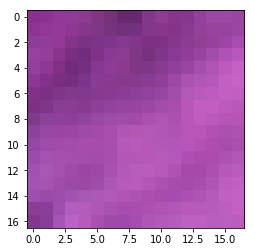

DONE!!!


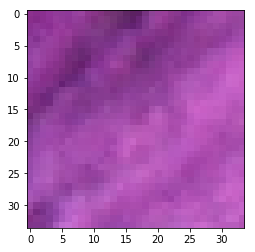

In [71]:
"""
Downsample images
- gaussian blur
- resize by downsample factor (using interpolation)

How To Use:
    function lr_dataset_from_path takes a path to the dataset of HR image png files and returns an ndarray to use for training the model
    
For debugging/showing examples:
    (see bottom of file)
    save_png set to True to save resulting lr images in specified directory.
    !check the param_ varaiables
"""

SUBSAMPLING_STRIDE_SIZE = 14
SUBSAMPLING_SAMPLE_SIZE = 17


# hr_dataset_path: dir to the hr_dataset png files
# downscale: downscale factor, e.g. if original image 64*64 and downscale=2 then result will be 32*32
# returns list of numpy.ndarray representing the lr_images
def lr_dataset_from_path(hr_dataset_path, downscale):
    original_filenames = os.listdir(hr_dataset_path)
    original_images = []
    for file in original_filenames:
        original_images.append(plt.imread(hr_dataset_path + '/' + file))
    return lr_images(original_images, downscale)  # ndarray of images


def torchDataloader_from_path(hr_dataset_path, downscale, gaussian_sigma):
    original_filenames = os.listdir(hr_dataset_path)
    original_images = []
    for file in original_filenames:
        original_images.append(plt.imread(hr_dataset_path + '/' + file))

    # subsample
    subsamples_hr = []
    subsamples_hr_rev_shuff = []
    for i in range(len(original_images)):
        temp_subsamples = subsample(original_images[i], downscale)
        subsamples_hr += temp_subsamples
        for sample_indx in range(len(temp_subsamples)):
            subsamples_hr_rev_shuff.append(PS_inv(temp_subsamples[sample_indx], downscale))  # labels
    lr_dataset = lr_images(subsamples_hr, downscale, gaussian_sigma)  # ndarray of images

    return toDataloader(lr_dataset, subsamples_hr_rev_shuff)


# Takes list of images and provide LR images in form of numpy array
def lr_images(images_real, downscale, gaussianSigma):
    lr_images = []
    for img in range(len(images_real)):
        img_blurred = gaussian(images_real[img], sigma=gaussianSigma,
                               multichannel=True)  # multichannel blurr so that 3rd channel is not blurred
        lr_images.append(resize(img_blurred, (img_blurred.shape[0] // downscale, img_blurred.shape[1] // downscale)))
    return lr_images


# extract a 17r*17r subsample from original image, no overlap so every pixel appears at most once in output
def subsample(image_real, downscale):
    subsample_size = SUBSAMPLING_SAMPLE_SIZE * downscale
    subsample_stride = SUBSAMPLING_STRIDE_SIZE * downscale
    subsamples = []
    for y in range(math.floor((image_real.shape[0] - (subsample_size - subsample_stride)) / subsample_stride)):
        for x in range(math.floor((image_real.shape[1] - (subsample_size - subsample_stride)) / subsample_stride)):
            ss = image_real[(y * subsample_stride):(y * subsample_stride) + subsample_size,
                 (x * subsample_stride):(x * subsample_stride) + subsample_size]
            subsamples.append(ss)

    return subsamples


# returns a torch Dataloader (to iterate over training data) using the training data samples and traing data labels
def toDataloader(train_data, train_labels):
    labeled_data = []
    for i in range(len(train_data)):
        print(train_data[i].shape)
        print(train_labels[i].shape)
        labeled_data.append([np.transpose(train_data[i], (2, 0, 1)), np.transpose(train_labels[i], (2, 0, 1))])
    trainDataloader = DataLoader(labeled_data)
    return trainDataloader


# ---DEBUG--- uncomment to show first image
# pyplot.imshow(original_images[0])
# pyplot.imshow(lr_dataset[0])

# ----TEST DATALOADER ----
dataloader = torchDataloader_from_path('datasets/T91', r, blur)

print("TESTIng datalaoder iter")
i1, l1 = next(iter(dataloader))
imshow(i1[0])
plt.imshow(PS(l1[0], r))

print("DONE!!!")

In [72]:
use_gpu = torch.cuda.is_available()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(C, 64, 5, padding=2)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, r*r*C, 3, padding=1)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = self.conv3(x)
        return x


net = Net()
net.double()

if use_gpu:
    net = net.cuda()

In [73]:
# define loss fuction
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=lr_start, momentum=0.9) # momentum???
# scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', threshold=u, min_lr=lr_end)

In [77]:
losses = []

for epoch in range(100):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.double())
        loss = criterion(outputs, labels)
        loss.backward()
#         sceduler.step()
        optimizer.step()

        # print statistics
        epoch_loss += outputs.shape[0] * loss.item()
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
    print(epoch+1, epoch_loss / len(inputs))    
    losses.append(epoch_loss / len(inputs))
        

print('Finished Training')

[1,    10] loss: 0.00063
[1,    20] loss: 0.00123
[1,    30] loss: 0.00075
[1,    40] loss: 0.00333
[1,    50] loss: 0.00685
[1,    60] loss: 0.00383
[1,    70] loss: 0.00316
[1,    80] loss: 0.00299
[1,    90] loss: 0.00298
[1,   100] loss: 0.00155
[1,   110] loss: 0.00065
[1,   120] loss: 0.00070
[1,   130] loss: 0.00063
[1,   140] loss: 0.00056
[1,   150] loss: 0.00017
[1,   160] loss: 0.00010
[1,   170] loss: 0.00024
[1,   180] loss: 0.00061
[1,   190] loss: 0.00084
[1,   200] loss: 0.00094
[1,   210] loss: 0.00103
[1,   220] loss: 0.00074
[1,   230] loss: 0.00054
[1,   240] loss: 0.00062
[1,   250] loss: 0.00198
[1,   260] loss: 0.00124
[1,   270] loss: 0.00211
[1,   280] loss: 0.00241
[1,   290] loss: 0.00109
[1,   300] loss: 0.00097
[1,   310] loss: 0.00138
[1,   320] loss: 0.00068
[1,   330] loss: 0.00095
[1,   340] loss: 0.00136
[1,   350] loss: 0.00143
[1,   360] loss: 0.00074
[1,   370] loss: 0.00048
[1,   380] loss: 0.00051
[1,   390] loss: 0.00027
[1,   400] loss: 0.00036


[2,  1400] loss: 0.00435
[2,  1410] loss: 0.00292
[2,  1420] loss: 0.00338
[2,  1430] loss: 0.00064
[2,  1440] loss: 0.00210
[2,  1450] loss: 0.00092
[2,  1460] loss: 0.00132
[2,  1470] loss: 0.00123
[2,  1480] loss: 0.00108
[2,  1490] loss: 0.00106
[2,  1500] loss: 0.00068
[2,  1510] loss: 0.00086
[2,  1520] loss: 0.00093
[2,  1530] loss: 0.00042
[2,  1540] loss: 0.00109
[2,  1550] loss: 0.00057
[2,  1560] loss: 0.00053
[2,  1570] loss: 0.00067
[2,  1580] loss: 0.00088
[2,  1590] loss: 0.00095
[2,  1600] loss: 0.00059
[2,  1610] loss: 0.00140
[2,  1620] loss: 0.00112
[2,  1630] loss: 0.00168
[2,  1640] loss: 0.00104
[2,  1650] loss: 0.00040
[2,  1660] loss: 0.00025
[2,  1670] loss: 0.00032
[2,  1680] loss: 0.00029
[2,  1690] loss: 0.00054
[2,  1700] loss: 0.00043
[2,  1710] loss: 0.00044
[2,  1720] loss: 0.00044
[2,  1730] loss: 0.00056
[2,  1740] loss: 0.00044
[2,  1750] loss: 0.00059
[2,  1760] loss: 0.00055
[2,  1770] loss: 0.00172
[2,  1780] loss: 0.00208
[2,  1790] loss: 0.00227


[4,   920] loss: 0.00257
[4,   930] loss: 0.00214
[4,   940] loss: 0.00155
[4,   950] loss: 0.00170
[4,   960] loss: 0.00047
[4,   970] loss: 0.00025
[4,   980] loss: 0.00028
[4,   990] loss: 0.00026
[4,  1000] loss: 0.00037
[4,  1010] loss: 0.00042
[4,  1020] loss: 0.00058
[4,  1030] loss: 0.00089
[4,  1040] loss: 0.00113
[4,  1050] loss: 0.00080
[4,  1060] loss: 0.00107
[4,  1070] loss: 0.00068
[4,  1080] loss: 0.00053
[4,  1090] loss: 0.00042
[4,  1100] loss: 0.00066
[4,  1110] loss: 0.00124
[4,  1120] loss: 0.00164
[4,  1130] loss: 0.00190
[4,  1140] loss: 0.00209
[4,  1150] loss: 0.00147
[4,  1160] loss: 0.00174
[4,  1170] loss: 0.00199
[4,  1180] loss: 0.00164
[4,  1190] loss: 0.00157
[4,  1200] loss: 0.00178
[4,  1210] loss: 0.00183
[4,  1220] loss: 0.00092
[4,  1230] loss: 0.00052
[4,  1240] loss: 0.00037
[4,  1250] loss: 0.00051
[4,  1260] loss: 0.00038
[4,  1270] loss: 0.00040
[4,  1280] loss: 0.00041
[4,  1290] loss: 0.00081
[4,  1300] loss: 0.00082
[4,  1310] loss: 0.00035


[6,   440] loss: 0.00061
[6,   450] loss: 0.00041
[6,   460] loss: 0.00081
[6,   470] loss: 0.00158
[6,   480] loss: 0.00356
[6,   490] loss: 0.00403
[6,   500] loss: 0.00298
[6,   510] loss: 0.00267
[6,   520] loss: 0.00279
[6,   530] loss: 0.00119
[6,   540] loss: 0.00069
[6,   550] loss: 0.00340
[6,   560] loss: 0.00355
[6,   570] loss: 0.00359
[6,   580] loss: 0.00205
[6,   590] loss: 0.00029
[6,   600] loss: 0.00041
[6,   610] loss: 0.00058
[6,   620] loss: 0.00125
[6,   630] loss: 0.00134
[6,   640] loss: 0.00096
[6,   650] loss: 0.00109
[6,   660] loss: 0.00130
[6,   670] loss: 0.00165
[6,   680] loss: 0.00174
[6,   690] loss: 0.00058
[6,   700] loss: 0.00066
[6,   710] loss: 0.00085
[6,   720] loss: 0.00138
[6,   730] loss: 0.00038
[6,   740] loss: 0.00043
[6,   750] loss: 0.00079
[6,   760] loss: 0.00095
[6,   770] loss: 0.00107
[6,   780] loss: 0.00111
[6,   790] loss: 0.00101
[6,   800] loss: 0.00273
[6,   810] loss: 0.00269
[6,   820] loss: 0.00263
[6,   830] loss: 0.00203


[7,  1830] loss: 0.00276
[7,  1840] loss: 0.00457
[7,  1850] loss: 0.00535
[7,  1860] loss: 0.00522
[7,  1870] loss: 0.00102
7 2.4410332198657936
[8,    10] loss: 0.00058
[8,    20] loss: 0.00115
[8,    30] loss: 0.00070
[8,    40] loss: 0.00317
[8,    50] loss: 0.00658
[8,    60] loss: 0.00365
[8,    70] loss: 0.00301
[8,    80] loss: 0.00285
[8,    90] loss: 0.00284
[8,   100] loss: 0.00149
[8,   110] loss: 0.00060
[8,   120] loss: 0.00063
[8,   130] loss: 0.00057
[8,   140] loss: 0.00051
[8,   150] loss: 0.00016
[8,   160] loss: 0.00009
[8,   170] loss: 0.00022
[8,   180] loss: 0.00057
[8,   190] loss: 0.00076
[8,   200] loss: 0.00085
[8,   210] loss: 0.00094
[8,   220] loss: 0.00063
[8,   230] loss: 0.00047
[8,   240] loss: 0.00057
[8,   250] loss: 0.00190
[8,   260] loss: 0.00119
[8,   270] loss: 0.00203
[8,   280] loss: 0.00232
[8,   290] loss: 0.00103
[8,   300] loss: 0.00089
[8,   310] loss: 0.00129
[8,   320] loss: 0.00060
[8,   330] loss: 0.00084
[8,   340] loss: 0.00128
[8, 

[9,  1350] loss: 0.00072
[9,  1360] loss: 0.00083
[9,  1370] loss: 0.00049
[9,  1380] loss: 0.00079
[9,  1390] loss: 0.00349
[9,  1400] loss: 0.00417
[9,  1410] loss: 0.00279
[9,  1420] loss: 0.00324
[9,  1430] loss: 0.00059
[9,  1440] loss: 0.00200
[9,  1450] loss: 0.00086
[9,  1460] loss: 0.00126
[9,  1470] loss: 0.00115
[9,  1480] loss: 0.00101
[9,  1490] loss: 0.00099
[9,  1500] loss: 0.00062
[9,  1510] loss: 0.00080
[9,  1520] loss: 0.00086
[9,  1530] loss: 0.00038
[9,  1540] loss: 0.00101
[9,  1550] loss: 0.00052
[9,  1560] loss: 0.00049
[9,  1570] loss: 0.00062
[9,  1580] loss: 0.00082
[9,  1590] loss: 0.00088
[9,  1600] loss: 0.00054
[9,  1610] loss: 0.00131
[9,  1620] loss: 0.00104
[9,  1630] loss: 0.00156
[9,  1640] loss: 0.00098
[9,  1650] loss: 0.00037
[9,  1660] loss: 0.00022
[9,  1670] loss: 0.00029
[9,  1680] loss: 0.00026
[9,  1690] loss: 0.00050
[9,  1700] loss: 0.00039
[9,  1710] loss: 0.00041
[9,  1720] loss: 0.00040
[9,  1730] loss: 0.00052
[9,  1740] loss: 0.00041


[11,   760] loss: 0.00091
[11,   770] loss: 0.00103
[11,   780] loss: 0.00108
[11,   790] loss: 0.00098
[11,   800] loss: 0.00263
[11,   810] loss: 0.00256
[11,   820] loss: 0.00248
[11,   830] loss: 0.00195
[11,   840] loss: 0.00130
[11,   850] loss: 0.00188
[11,   860] loss: 0.00178
[11,   870] loss: 0.00206
[11,   880] loss: 0.00227
[11,   890] loss: 0.00193
[11,   900] loss: 0.00255
[11,   910] loss: 0.00248
[11,   920] loss: 0.00249
[11,   930] loss: 0.00206
[11,   940] loss: 0.00149
[11,   950] loss: 0.00163
[11,   960] loss: 0.00044
[11,   970] loss: 0.00022
[11,   980] loss: 0.00025
[11,   990] loss: 0.00023
[11,  1000] loss: 0.00034
[11,  1010] loss: 0.00038
[11,  1020] loss: 0.00054
[11,  1030] loss: 0.00085
[11,  1040] loss: 0.00108
[11,  1050] loss: 0.00076
[11,  1060] loss: 0.00102
[11,  1070] loss: 0.00064
[11,  1080] loss: 0.00050
[11,  1090] loss: 0.00040
[11,  1100] loss: 0.00061
[11,  1110] loss: 0.00116
[11,  1120] loss: 0.00154
[11,  1130] loss: 0.00180
[11,  1140] 

[13,   150] loss: 0.00015
[13,   160] loss: 0.00009
[13,   170] loss: 0.00021
[13,   180] loss: 0.00055
[13,   190] loss: 0.00071
[13,   200] loss: 0.00081
[13,   210] loss: 0.00089
[13,   220] loss: 0.00058
[13,   230] loss: 0.00044
[13,   240] loss: 0.00055
[13,   250] loss: 0.00186
[13,   260] loss: 0.00117
[13,   270] loss: 0.00199
[13,   280] loss: 0.00227
[13,   290] loss: 0.00099
[13,   300] loss: 0.00085
[13,   310] loss: 0.00126
[13,   320] loss: 0.00056
[13,   330] loss: 0.00079
[13,   340] loss: 0.00124
[13,   350] loss: 0.00131
[13,   360] loss: 0.00060
[13,   370] loss: 0.00040
[13,   380] loss: 0.00045
[13,   390] loss: 0.00021
[13,   400] loss: 0.00030
[13,   410] loss: 0.00036
[13,   420] loss: 0.00023
[13,   430] loss: 0.00024
[13,   440] loss: 0.00057
[13,   450] loss: 0.00038
[13,   460] loss: 0.00077
[13,   470] loss: 0.00152
[13,   480] loss: 0.00343
[13,   490] loss: 0.00387
[13,   500] loss: 0.00286
[13,   510] loss: 0.00257
[13,   520] loss: 0.00269
[13,   530] 

[14,  1420] loss: 0.00317
[14,  1430] loss: 0.00057
[14,  1440] loss: 0.00196
[14,  1450] loss: 0.00083
[14,  1460] loss: 0.00123
[14,  1470] loss: 0.00111
[14,  1480] loss: 0.00098
[14,  1490] loss: 0.00095
[14,  1500] loss: 0.00059
[14,  1510] loss: 0.00077
[14,  1520] loss: 0.00083
[14,  1530] loss: 0.00036
[14,  1540] loss: 0.00097
[14,  1550] loss: 0.00050
[14,  1560] loss: 0.00047
[14,  1570] loss: 0.00059
[14,  1580] loss: 0.00079
[14,  1590] loss: 0.00085
[14,  1600] loss: 0.00051
[14,  1610] loss: 0.00127
[14,  1620] loss: 0.00100
[14,  1630] loss: 0.00151
[14,  1640] loss: 0.00094
[14,  1650] loss: 0.00035
[14,  1660] loss: 0.00020
[14,  1670] loss: 0.00027
[14,  1680] loss: 0.00024
[14,  1690] loss: 0.00048
[14,  1700] loss: 0.00038
[14,  1710] loss: 0.00039
[14,  1720] loss: 0.00038
[14,  1730] loss: 0.00050
[14,  1740] loss: 0.00040
[14,  1750] loss: 0.00053
[14,  1760] loss: 0.00050
[14,  1770] loss: 0.00151
[14,  1780] loss: 0.00181
[14,  1790] loss: 0.00195
[14,  1800] 

[16,   810] loss: 0.00245
[16,   820] loss: 0.00236
[16,   830] loss: 0.00188
[16,   840] loss: 0.00127
[16,   850] loss: 0.00183
[16,   860] loss: 0.00171
[16,   870] loss: 0.00201
[16,   880] loss: 0.00221
[16,   890] loss: 0.00188
[16,   900] loss: 0.00250
[16,   910] loss: 0.00243
[16,   920] loss: 0.00244
[16,   930] loss: 0.00202
[16,   940] loss: 0.00146
[16,   950] loss: 0.00160
[16,   960] loss: 0.00043
[16,   970] loss: 0.00021
[16,   980] loss: 0.00023
[16,   990] loss: 0.00022
[16,  1000] loss: 0.00032
[16,  1010] loss: 0.00037
[16,  1020] loss: 0.00052
[16,  1030] loss: 0.00083
[16,  1040] loss: 0.00106
[16,  1050] loss: 0.00074
[16,  1060] loss: 0.00099
[16,  1070] loss: 0.00062
[16,  1080] loss: 0.00049
[16,  1090] loss: 0.00039
[16,  1100] loss: 0.00059
[16,  1110] loss: 0.00112
[16,  1120] loss: 0.00149
[16,  1130] loss: 0.00175
[16,  1140] loss: 0.00193
[16,  1150] loss: 0.00134
[16,  1160] loss: 0.00163
[16,  1170] loss: 0.00186
[16,  1180] loss: 0.00153
[16,  1190] 

[18,   200] loss: 0.00077
[18,   210] loss: 0.00085
[18,   220] loss: 0.00054
[18,   230] loss: 0.00041
[18,   240] loss: 0.00053
[18,   250] loss: 0.00183
[18,   260] loss: 0.00115
[18,   270] loss: 0.00195
[18,   280] loss: 0.00224
[18,   290] loss: 0.00097
[18,   300] loss: 0.00082
[18,   310] loss: 0.00122
[18,   320] loss: 0.00053
[18,   330] loss: 0.00075
[18,   340] loss: 0.00121
[18,   350] loss: 0.00128
[18,   360] loss: 0.00057
[18,   370] loss: 0.00038
[18,   380] loss: 0.00043
[18,   390] loss: 0.00020
[18,   400] loss: 0.00029
[18,   410] loss: 0.00034
[18,   420] loss: 0.00022
[18,   430] loss: 0.00022
[18,   440] loss: 0.00055
[18,   450] loss: 0.00036
[18,   460] loss: 0.00075
[18,   470] loss: 0.00148
[18,   480] loss: 0.00335
[18,   490] loss: 0.00378
[18,   500] loss: 0.00279
[18,   510] loss: 0.00251
[18,   520] loss: 0.00263
[18,   530] loss: 0.00110
[18,   540] loss: 0.00064
[18,   550] loss: 0.00324
[18,   560] loss: 0.00335
[18,   570] loss: 0.00341
[18,   580] 

[19,  1470] loss: 0.00108
[19,  1480] loss: 0.00095
[19,  1490] loss: 0.00092
[19,  1500] loss: 0.00057
[19,  1510] loss: 0.00074
[19,  1520] loss: 0.00080
[19,  1530] loss: 0.00035
[19,  1540] loss: 0.00094
[19,  1550] loss: 0.00048
[19,  1560] loss: 0.00045
[19,  1570] loss: 0.00056
[19,  1580] loss: 0.00076
[19,  1590] loss: 0.00082
[19,  1600] loss: 0.00049
[19,  1610] loss: 0.00123
[19,  1620] loss: 0.00097
[19,  1630] loss: 0.00146
[19,  1640] loss: 0.00092
[19,  1650] loss: 0.00033
[19,  1660] loss: 0.00019
[19,  1670] loss: 0.00026
[19,  1680] loss: 0.00023
[19,  1690] loss: 0.00047
[19,  1700] loss: 0.00036
[19,  1710] loss: 0.00038
[19,  1720] loss: 0.00036
[19,  1730] loss: 0.00048
[19,  1740] loss: 0.00039
[19,  1750] loss: 0.00052
[19,  1760] loss: 0.00048
[19,  1770] loss: 0.00145
[19,  1780] loss: 0.00173
[19,  1790] loss: 0.00186
[19,  1800] loss: 0.00092
[19,  1810] loss: 0.00082
[19,  1820] loss: 0.00049
[19,  1830] loss: 0.00258
[19,  1840] loss: 0.00435
[19,  1850] 

[21,   860] loss: 0.00167
[21,   870] loss: 0.00197
[21,   880] loss: 0.00216
[21,   890] loss: 0.00185
[21,   900] loss: 0.00246
[21,   910] loss: 0.00239
[21,   920] loss: 0.00240
[21,   930] loss: 0.00199
[21,   940] loss: 0.00143
[21,   950] loss: 0.00157
[21,   960] loss: 0.00042
[21,   970] loss: 0.00020
[21,   980] loss: 0.00022
[21,   990] loss: 0.00021
[21,  1000] loss: 0.00031
[21,  1010] loss: 0.00035
[21,  1020] loss: 0.00051
[21,  1030] loss: 0.00081
[21,  1040] loss: 0.00104
[21,  1050] loss: 0.00073
[21,  1060] loss: 0.00097
[21,  1070] loss: 0.00061
[21,  1080] loss: 0.00048
[21,  1090] loss: 0.00038
[21,  1100] loss: 0.00057
[21,  1110] loss: 0.00109
[21,  1120] loss: 0.00145
[21,  1130] loss: 0.00171
[21,  1140] loss: 0.00189
[21,  1150] loss: 0.00130
[21,  1160] loss: 0.00160
[21,  1170] loss: 0.00182
[21,  1180] loss: 0.00150
[21,  1190] loss: 0.00142
[21,  1200] loss: 0.00164
[21,  1210] loss: 0.00168
[21,  1220] loss: 0.00080
[21,  1230] loss: 0.00043
[21,  1240] 

[23,   250] loss: 0.00181
[23,   260] loss: 0.00113
[23,   270] loss: 0.00192
[23,   280] loss: 0.00221
[23,   290] loss: 0.00095
[23,   300] loss: 0.00079
[23,   310] loss: 0.00120
[23,   320] loss: 0.00051
[23,   330] loss: 0.00072
[23,   340] loss: 0.00118
[23,   350] loss: 0.00126
[23,   360] loss: 0.00054
[23,   370] loss: 0.00036
[23,   380] loss: 0.00042
[23,   390] loss: 0.00019
[23,   400] loss: 0.00028
[23,   410] loss: 0.00033
[23,   420] loss: 0.00021
[23,   430] loss: 0.00021
[23,   440] loss: 0.00053
[23,   450] loss: 0.00035
[23,   460] loss: 0.00073
[23,   470] loss: 0.00146
[23,   480] loss: 0.00330
[23,   490] loss: 0.00371
[23,   500] loss: 0.00274
[23,   510] loss: 0.00246
[23,   520] loss: 0.00259
[23,   530] loss: 0.00108
[23,   540] loss: 0.00063
[23,   550] loss: 0.00320
[23,   560] loss: 0.00329
[23,   570] loss: 0.00336
[23,   580] loss: 0.00187
[23,   590] loss: 0.00024
[23,   600] loss: 0.00035
[23,   610] loss: 0.00050
[23,   620] loss: 0.00110
[23,   630] 

[24,  1520] loss: 0.00078
[24,  1530] loss: 0.00034
[24,  1540] loss: 0.00092
[24,  1550] loss: 0.00047
[24,  1560] loss: 0.00044
[24,  1570] loss: 0.00054
[24,  1580] loss: 0.00074
[24,  1590] loss: 0.00080
[24,  1600] loss: 0.00047
[24,  1610] loss: 0.00120
[24,  1620] loss: 0.00095
[24,  1630] loss: 0.00143
[24,  1640] loss: 0.00089
[24,  1650] loss: 0.00032
[24,  1660] loss: 0.00018
[24,  1670] loss: 0.00025
[24,  1680] loss: 0.00022
[24,  1690] loss: 0.00045
[24,  1700] loss: 0.00035
[24,  1710] loss: 0.00036
[24,  1720] loss: 0.00035
[24,  1730] loss: 0.00046
[24,  1740] loss: 0.00038
[24,  1750] loss: 0.00050
[24,  1760] loss: 0.00046
[24,  1770] loss: 0.00139
[24,  1780] loss: 0.00166
[24,  1790] loss: 0.00178
[24,  1800] loss: 0.00088
[24,  1810] loss: 0.00079
[24,  1820] loss: 0.00047
[24,  1830] loss: 0.00253
[24,  1840] loss: 0.00429
[24,  1850] loss: 0.00501
[24,  1860] loss: 0.00494
[24,  1870] loss: 0.00096
24 2.224200268413183
[25,    10] loss: 0.00050
[25,    20] loss:

[26,   910] loss: 0.00236
[26,   920] loss: 0.00237
[26,   930] loss: 0.00196
[26,   940] loss: 0.00141
[26,   950] loss: 0.00155
[26,   960] loss: 0.00040
[26,   970] loss: 0.00019
[26,   980] loss: 0.00021
[26,   990] loss: 0.00021
[26,  1000] loss: 0.00030
[26,  1010] loss: 0.00034
[26,  1020] loss: 0.00050
[26,  1030] loss: 0.00079
[26,  1040] loss: 0.00102
[26,  1050] loss: 0.00071
[26,  1060] loss: 0.00096
[26,  1070] loss: 0.00060
[26,  1080] loss: 0.00047
[26,  1090] loss: 0.00037
[26,  1100] loss: 0.00055
[26,  1110] loss: 0.00106
[26,  1120] loss: 0.00141
[26,  1130] loss: 0.00167
[26,  1140] loss: 0.00185
[26,  1150] loss: 0.00127
[26,  1160] loss: 0.00158
[26,  1170] loss: 0.00179
[26,  1180] loss: 0.00147
[26,  1190] loss: 0.00139
[26,  1200] loss: 0.00161
[26,  1210] loss: 0.00165
[26,  1220] loss: 0.00078
[26,  1230] loss: 0.00041
[26,  1240] loss: 0.00030
[26,  1250] loss: 0.00043
[26,  1260] loss: 0.00032
[26,  1270] loss: 0.00033
[26,  1280] loss: 0.00036
[26,  1290] 

[28,   300] loss: 0.00077
[28,   310] loss: 0.00118
[28,   320] loss: 0.00049
[28,   330] loss: 0.00069
[28,   340] loss: 0.00116
[28,   350] loss: 0.00124
[28,   360] loss: 0.00052
[28,   370] loss: 0.00035
[28,   380] loss: 0.00041
[28,   390] loss: 0.00018
[28,   400] loss: 0.00026
[28,   410] loss: 0.00031
[28,   420] loss: 0.00019
[28,   430] loss: 0.00020
[28,   440] loss: 0.00051
[28,   450] loss: 0.00034
[28,   460] loss: 0.00072
[28,   470] loss: 0.00143
[28,   480] loss: 0.00325
[28,   490] loss: 0.00366
[28,   500] loss: 0.00270
[28,   510] loss: 0.00243
[28,   520] loss: 0.00255
[28,   530] loss: 0.00106
[28,   540] loss: 0.00062
[28,   550] loss: 0.00316
[28,   560] loss: 0.00324
[28,   570] loss: 0.00331
[28,   580] loss: 0.00184
[28,   590] loss: 0.00024
[28,   600] loss: 0.00034
[28,   610] loss: 0.00049
[28,   620] loss: 0.00107
[28,   630] loss: 0.00119
[28,   640] loss: 0.00084
[28,   650] loss: 0.00097
[28,   660] loss: 0.00115
[28,   670] loss: 0.00150
[28,   680] 

[29,  1570] loss: 0.00053
[29,  1580] loss: 0.00073
[29,  1590] loss: 0.00078
[29,  1600] loss: 0.00046
[29,  1610] loss: 0.00117
[29,  1620] loss: 0.00093
[29,  1630] loss: 0.00140
[29,  1640] loss: 0.00087
[29,  1650] loss: 0.00031
[29,  1660] loss: 0.00017
[29,  1670] loss: 0.00024
[29,  1680] loss: 0.00021
[29,  1690] loss: 0.00044
[29,  1700] loss: 0.00034
[29,  1710] loss: 0.00035
[29,  1720] loss: 0.00034
[29,  1730] loss: 0.00045
[29,  1740] loss: 0.00037
[29,  1750] loss: 0.00049
[29,  1760] loss: 0.00045
[29,  1770] loss: 0.00135
[29,  1780] loss: 0.00161
[29,  1790] loss: 0.00172
[29,  1800] loss: 0.00085
[29,  1810] loss: 0.00076
[29,  1820] loss: 0.00046
[29,  1830] loss: 0.00249
[29,  1840] loss: 0.00424
[29,  1850] loss: 0.00495
[29,  1860] loss: 0.00489
[29,  1870] loss: 0.00095
29 2.1833757023847804
[30,    10] loss: 0.00048
[30,    20] loss: 0.00103
[30,    30] loss: 0.00062
[30,    40] loss: 0.00292
[30,    50] loss: 0.00617
[30,    60] loss: 0.00336
[30,    70] loss

[31,   960] loss: 0.00040
[31,   970] loss: 0.00018
[31,   980] loss: 0.00020
[31,   990] loss: 0.00020
[31,  1000] loss: 0.00029
[31,  1010] loss: 0.00033
[31,  1020] loss: 0.00048
[31,  1030] loss: 0.00078
[31,  1040] loss: 0.00101
[31,  1050] loss: 0.00070
[31,  1060] loss: 0.00094
[31,  1070] loss: 0.00059
[31,  1080] loss: 0.00047
[31,  1090] loss: 0.00036
[31,  1100] loss: 0.00054
[31,  1110] loss: 0.00104
[31,  1120] loss: 0.00138
[31,  1130] loss: 0.00164
[31,  1140] loss: 0.00182
[31,  1150] loss: 0.00124
[31,  1160] loss: 0.00156
[31,  1170] loss: 0.00176
[31,  1180] loss: 0.00145
[31,  1190] loss: 0.00137
[31,  1200] loss: 0.00158
[31,  1210] loss: 0.00163
[31,  1220] loss: 0.00075
[31,  1230] loss: 0.00039
[31,  1240] loss: 0.00029
[31,  1250] loss: 0.00042
[31,  1260] loss: 0.00031
[31,  1270] loss: 0.00033
[31,  1280] loss: 0.00035
[31,  1290] loss: 0.00069
[31,  1300] loss: 0.00067
[31,  1310] loss: 0.00025
[31,  1320] loss: 0.00066
[31,  1330] loss: 0.00094
[31,  1340] 

[33,   350] loss: 0.00122
[33,   360] loss: 0.00050
[33,   370] loss: 0.00034
[33,   380] loss: 0.00040
[33,   390] loss: 0.00017
[33,   400] loss: 0.00026
[33,   410] loss: 0.00030
[33,   420] loss: 0.00019
[33,   430] loss: 0.00019
[33,   440] loss: 0.00050
[33,   450] loss: 0.00033
[33,   460] loss: 0.00071
[33,   470] loss: 0.00142
[33,   480] loss: 0.00321
[33,   490] loss: 0.00361
[33,   500] loss: 0.00266
[33,   510] loss: 0.00240
[33,   520] loss: 0.00252
[33,   530] loss: 0.00104
[33,   540] loss: 0.00061
[33,   550] loss: 0.00313
[33,   560] loss: 0.00320
[33,   570] loss: 0.00328
[33,   580] loss: 0.00181
[33,   590] loss: 0.00023
[33,   600] loss: 0.00033
[33,   610] loss: 0.00048
[33,   620] loss: 0.00105
[33,   630] loss: 0.00117
[33,   640] loss: 0.00082
[33,   650] loss: 0.00096
[33,   660] loss: 0.00113
[33,   670] loss: 0.00148
[33,   680] loss: 0.00157
[33,   690] loss: 0.00049
[33,   700] loss: 0.00055
[33,   710] loss: 0.00071
[33,   720] loss: 0.00122
[33,   730] 

[34,  1620] loss: 0.00091
[34,  1630] loss: 0.00138
[34,  1640] loss: 0.00086
[34,  1650] loss: 0.00030
[34,  1660] loss: 0.00016
[34,  1670] loss: 0.00023
[34,  1680] loss: 0.00020
[34,  1690] loss: 0.00043
[34,  1700] loss: 0.00034
[34,  1710] loss: 0.00035
[34,  1720] loss: 0.00033
[34,  1730] loss: 0.00044
[34,  1740] loss: 0.00036
[34,  1750] loss: 0.00048
[34,  1760] loss: 0.00044
[34,  1770] loss: 0.00131
[34,  1780] loss: 0.00156
[34,  1790] loss: 0.00166
[34,  1800] loss: 0.00082
[34,  1810] loss: 0.00074
[34,  1820] loss: 0.00044
[34,  1830] loss: 0.00245
[34,  1840] loss: 0.00419
[34,  1850] loss: 0.00489
[34,  1860] loss: 0.00485
[34,  1870] loss: 0.00094
34 2.148491439130552
[35,    10] loss: 0.00046
[35,    20] loss: 0.00102
[35,    30] loss: 0.00060
[35,    40] loss: 0.00289
[35,    50] loss: 0.00611
[35,    60] loss: 0.00332
[35,    70] loss: 0.00276
[35,    80] loss: 0.00261
[35,    90] loss: 0.00259
[35,   100] loss: 0.00136
[35,   110] loss: 0.00051
[35,   120] loss:

[36,  1010] loss: 0.00032
[36,  1020] loss: 0.00048
[36,  1030] loss: 0.00077
[36,  1040] loss: 0.00100
[36,  1050] loss: 0.00069
[36,  1060] loss: 0.00093
[36,  1070] loss: 0.00058
[36,  1080] loss: 0.00046
[36,  1090] loss: 0.00036
[36,  1100] loss: 0.00053
[36,  1110] loss: 0.00102
[36,  1120] loss: 0.00136
[36,  1130] loss: 0.00162
[36,  1140] loss: 0.00179
[36,  1150] loss: 0.00122
[36,  1160] loss: 0.00154
[36,  1170] loss: 0.00174
[36,  1180] loss: 0.00143
[36,  1190] loss: 0.00135
[36,  1200] loss: 0.00156
[36,  1210] loss: 0.00160
[36,  1220] loss: 0.00073
[36,  1230] loss: 0.00038
[36,  1240] loss: 0.00028
[36,  1250] loss: 0.00041
[36,  1260] loss: 0.00030
[36,  1270] loss: 0.00032
[36,  1280] loss: 0.00034
[36,  1290] loss: 0.00068
[36,  1300] loss: 0.00065
[36,  1310] loss: 0.00024
[36,  1320] loss: 0.00064
[36,  1330] loss: 0.00092
[36,  1340] loss: 0.00081
[36,  1350] loss: 0.00064
[36,  1360] loss: 0.00074
[36,  1370] loss: 0.00044
[36,  1380] loss: 0.00071
[36,  1390] 

[38,   400] loss: 0.00025
[38,   410] loss: 0.00029
[38,   420] loss: 0.00018
[38,   430] loss: 0.00018
[38,   440] loss: 0.00049
[38,   450] loss: 0.00032
[38,   460] loss: 0.00070
[38,   470] loss: 0.00140
[38,   480] loss: 0.00317
[38,   490] loss: 0.00357
[38,   500] loss: 0.00263
[38,   510] loss: 0.00237
[38,   520] loss: 0.00250
[38,   530] loss: 0.00103
[38,   540] loss: 0.00060
[38,   550] loss: 0.00310
[38,   560] loss: 0.00317
[38,   570] loss: 0.00325
[38,   580] loss: 0.00179
[38,   590] loss: 0.00022
[38,   600] loss: 0.00032
[38,   610] loss: 0.00047
[38,   620] loss: 0.00103
[38,   630] loss: 0.00115
[38,   640] loss: 0.00081
[38,   650] loss: 0.00094
[38,   660] loss: 0.00111
[38,   670] loss: 0.00146
[38,   680] loss: 0.00155
[38,   690] loss: 0.00048
[38,   700] loss: 0.00054
[38,   710] loss: 0.00069
[38,   720] loss: 0.00121
[38,   730] loss: 0.00033
[38,   740] loss: 0.00039
[38,   750] loss: 0.00069
[38,   760] loss: 0.00080
[38,   770] loss: 0.00091
[38,   780] 

[39,  1670] loss: 0.00023
[39,  1680] loss: 0.00020
[39,  1690] loss: 0.00042
[39,  1700] loss: 0.00033
[39,  1710] loss: 0.00034
[39,  1720] loss: 0.00033
[39,  1730] loss: 0.00043
[39,  1740] loss: 0.00035
[39,  1750] loss: 0.00047
[39,  1760] loss: 0.00043
[39,  1770] loss: 0.00127
[39,  1780] loss: 0.00151
[39,  1790] loss: 0.00161
[39,  1800] loss: 0.00080
[39,  1810] loss: 0.00073
[39,  1820] loss: 0.00043
[39,  1830] loss: 0.00242
[39,  1840] loss: 0.00415
[39,  1850] loss: 0.00484
[39,  1860] loss: 0.00481
[39,  1870] loss: 0.00093
39 2.1182626977966454
[40,    10] loss: 0.00045
[40,    20] loss: 0.00100
[40,    30] loss: 0.00059
[40,    40] loss: 0.00286
[40,    50] loss: 0.00606
[40,    60] loss: 0.00329
[40,    70] loss: 0.00273
[40,    80] loss: 0.00258
[40,    90] loss: 0.00257
[40,   100] loss: 0.00135
[40,   110] loss: 0.00050
[40,   120] loss: 0.00048
[40,   130] loss: 0.00045
[40,   140] loss: 0.00040
[40,   150] loss: 0.00012
[40,   160] loss: 0.00007
[40,   170] loss

[41,  1060] loss: 0.00092
[41,  1070] loss: 0.00058
[41,  1080] loss: 0.00046
[41,  1090] loss: 0.00035
[41,  1100] loss: 0.00051
[41,  1110] loss: 0.00100
[41,  1120] loss: 0.00133
[41,  1130] loss: 0.00159
[41,  1140] loss: 0.00177
[41,  1150] loss: 0.00120
[41,  1160] loss: 0.00152
[41,  1170] loss: 0.00172
[41,  1180] loss: 0.00141
[41,  1190] loss: 0.00133
[41,  1200] loss: 0.00154
[41,  1210] loss: 0.00158
[41,  1220] loss: 0.00071
[41,  1230] loss: 0.00036
[41,  1240] loss: 0.00027
[41,  1250] loss: 0.00040
[41,  1260] loss: 0.00030
[41,  1270] loss: 0.00031
[41,  1280] loss: 0.00034
[41,  1290] loss: 0.00067
[41,  1300] loss: 0.00064
[41,  1310] loss: 0.00024
[41,  1320] loss: 0.00063
[41,  1330] loss: 0.00090
[41,  1340] loss: 0.00080
[41,  1350] loss: 0.00063
[41,  1360] loss: 0.00073
[41,  1370] loss: 0.00043
[41,  1380] loss: 0.00070
[41,  1390] loss: 0.00319
[41,  1400] loss: 0.00383
[41,  1410] loss: 0.00250
[41,  1420] loss: 0.00296
[41,  1430] loss: 0.00050
[41,  1440] 

[43,   450] loss: 0.00032
[43,   460] loss: 0.00069
[43,   470] loss: 0.00138
[43,   480] loss: 0.00314
[43,   490] loss: 0.00353
[43,   500] loss: 0.00261
[43,   510] loss: 0.00235
[43,   520] loss: 0.00247
[43,   530] loss: 0.00102
[43,   540] loss: 0.00059
[43,   550] loss: 0.00308
[43,   560] loss: 0.00314
[43,   570] loss: 0.00322
[43,   580] loss: 0.00177
[43,   590] loss: 0.00022
[43,   600] loss: 0.00032
[43,   610] loss: 0.00046
[43,   620] loss: 0.00101
[43,   630] loss: 0.00114
[43,   640] loss: 0.00080
[43,   650] loss: 0.00093
[43,   660] loss: 0.00110
[43,   670] loss: 0.00145
[43,   680] loss: 0.00154
[43,   690] loss: 0.00047
[43,   700] loss: 0.00052
[43,   710] loss: 0.00068
[43,   720] loss: 0.00119
[43,   730] loss: 0.00033
[43,   740] loss: 0.00039
[43,   750] loss: 0.00068
[43,   760] loss: 0.00079
[43,   770] loss: 0.00089
[43,   780] loss: 0.00097
[43,   790] loss: 0.00088
[43,   800] loss: 0.00232
[43,   810] loss: 0.00213
[43,   820] loss: 0.00201
[43,   830] 

[44,  1720] loss: 0.00032
[44,  1730] loss: 0.00042
[44,  1740] loss: 0.00035
[44,  1750] loss: 0.00046
[44,  1760] loss: 0.00042
[44,  1770] loss: 0.00124
[44,  1780] loss: 0.00147
[44,  1790] loss: 0.00157
[44,  1800] loss: 0.00078
[44,  1810] loss: 0.00071
[44,  1820] loss: 0.00042
[44,  1830] loss: 0.00240
[44,  1840] loss: 0.00412
[44,  1850] loss: 0.00480
[44,  1860] loss: 0.00478
[44,  1870] loss: 0.00092
44 2.0917604894259814
[45,    10] loss: 0.00044
[45,    20] loss: 0.00099
[45,    30] loss: 0.00058
[45,    40] loss: 0.00284
[45,    50] loss: 0.00602
[45,    60] loss: 0.00326
[45,    70] loss: 0.00271
[45,    80] loss: 0.00256
[45,    90] loss: 0.00254
[45,   100] loss: 0.00134
[45,   110] loss: 0.00050
[45,   120] loss: 0.00046
[45,   130] loss: 0.00044
[45,   140] loss: 0.00039
[45,   150] loss: 0.00012
[45,   160] loss: 0.00007
[45,   170] loss: 0.00019
[45,   180] loss: 0.00048
[45,   190] loss: 0.00056
[45,   200] loss: 0.00066
[45,   210] loss: 0.00071
[45,   220] loss

[46,  1110] loss: 0.00099
[46,  1120] loss: 0.00131
[46,  1130] loss: 0.00157
[46,  1140] loss: 0.00175
[46,  1150] loss: 0.00118
[46,  1160] loss: 0.00151
[46,  1170] loss: 0.00171
[46,  1180] loss: 0.00139
[46,  1190] loss: 0.00131
[46,  1200] loss: 0.00153
[46,  1210] loss: 0.00157
[46,  1220] loss: 0.00070
[46,  1230] loss: 0.00035
[46,  1240] loss: 0.00027
[46,  1250] loss: 0.00040
[46,  1260] loss: 0.00029
[46,  1270] loss: 0.00031
[46,  1280] loss: 0.00033
[46,  1290] loss: 0.00066
[46,  1300] loss: 0.00063
[46,  1310] loss: 0.00023
[46,  1320] loss: 0.00061
[46,  1330] loss: 0.00089
[46,  1340] loss: 0.00078
[46,  1350] loss: 0.00063
[46,  1360] loss: 0.00072
[46,  1370] loss: 0.00042
[46,  1380] loss: 0.00069
[46,  1390] loss: 0.00316
[46,  1400] loss: 0.00380
[46,  1410] loss: 0.00247
[46,  1420] loss: 0.00293
[46,  1430] loss: 0.00049
[46,  1440] loss: 0.00179
[46,  1450] loss: 0.00072
[46,  1460] loss: 0.00112
[46,  1470] loss: 0.00098
[46,  1480] loss: 0.00086
[46,  1490] 

[48,   500] loss: 0.00259
[48,   510] loss: 0.00233
[48,   520] loss: 0.00246
[48,   530] loss: 0.00101
[48,   540] loss: 0.00058
[48,   550] loss: 0.00306
[48,   560] loss: 0.00311
[48,   570] loss: 0.00319
[48,   580] loss: 0.00175
[48,   590] loss: 0.00021
[48,   600] loss: 0.00031
[48,   610] loss: 0.00045
[48,   620] loss: 0.00099
[48,   630] loss: 0.00113
[48,   640] loss: 0.00079
[48,   650] loss: 0.00092
[48,   660] loss: 0.00109
[48,   670] loss: 0.00144
[48,   680] loss: 0.00152
[48,   690] loss: 0.00046
[48,   700] loss: 0.00051
[48,   710] loss: 0.00066
[48,   720] loss: 0.00118
[48,   730] loss: 0.00033
[48,   740] loss: 0.00038
[48,   750] loss: 0.00067
[48,   760] loss: 0.00078
[48,   770] loss: 0.00088
[48,   780] loss: 0.00096
[48,   790] loss: 0.00087
[48,   800] loss: 0.00229
[48,   810] loss: 0.00210
[48,   820] loss: 0.00197
[48,   830] loss: 0.00164
[48,   840] loss: 0.00116
[48,   850] loss: 0.00165
[48,   860] loss: 0.00151
[48,   870] loss: 0.00184
[48,   880] 

[49,  1770] loss: 0.00122
[49,  1780] loss: 0.00144
[49,  1790] loss: 0.00153
[49,  1800] loss: 0.00076
[49,  1810] loss: 0.00070
[49,  1820] loss: 0.00041
[49,  1830] loss: 0.00238
[49,  1840] loss: 0.00409
[49,  1850] loss: 0.00476
[49,  1860] loss: 0.00475
[49,  1870] loss: 0.00091
49 2.068296824759758
[50,    10] loss: 0.00043
[50,    20] loss: 0.00098
[50,    30] loss: 0.00058
[50,    40] loss: 0.00282
[50,    50] loss: 0.00598
[50,    60] loss: 0.00323
[50,    70] loss: 0.00269
[50,    80] loss: 0.00254
[50,    90] loss: 0.00253
[50,   100] loss: 0.00133
[50,   110] loss: 0.00049
[50,   120] loss: 0.00045
[50,   130] loss: 0.00043
[50,   140] loss: 0.00038
[50,   150] loss: 0.00011
[50,   160] loss: 0.00007
[50,   170] loss: 0.00019
[50,   180] loss: 0.00048
[50,   190] loss: 0.00055
[50,   200] loss: 0.00064
[50,   210] loss: 0.00069
[50,   220] loss: 0.00040
[50,   230] loss: 0.00031
[50,   240] loss: 0.00046
[50,   250] loss: 0.00173
[50,   260] loss: 0.00107
[50,   270] loss:

[51,  1160] loss: 0.00150
[51,  1170] loss: 0.00169
[51,  1180] loss: 0.00138
[51,  1190] loss: 0.00130
[51,  1200] loss: 0.00151
[51,  1210] loss: 0.00155
[51,  1220] loss: 0.00068
[51,  1230] loss: 0.00034
[51,  1240] loss: 0.00026
[51,  1250] loss: 0.00039
[51,  1260] loss: 0.00029
[51,  1270] loss: 0.00030
[51,  1280] loss: 0.00033
[51,  1290] loss: 0.00066
[51,  1300] loss: 0.00062
[51,  1310] loss: 0.00023
[51,  1320] loss: 0.00060
[51,  1330] loss: 0.00087
[51,  1340] loss: 0.00077
[51,  1350] loss: 0.00062
[51,  1360] loss: 0.00072
[51,  1370] loss: 0.00042
[51,  1380] loss: 0.00069
[51,  1390] loss: 0.00314
[51,  1400] loss: 0.00377
[51,  1410] loss: 0.00245
[51,  1420] loss: 0.00291
[51,  1430] loss: 0.00048
[51,  1440] loss: 0.00178
[51,  1450] loss: 0.00071
[51,  1460] loss: 0.00111
[51,  1470] loss: 0.00097
[51,  1480] loss: 0.00085
[51,  1490] loss: 0.00083
[51,  1500] loss: 0.00049
[51,  1510] loss: 0.00066
[51,  1520] loss: 0.00072
[51,  1530] loss: 0.00031
[51,  1540] 

[53,   550] loss: 0.00305
[53,   560] loss: 0.00309
[53,   570] loss: 0.00317
[53,   580] loss: 0.00173
[53,   590] loss: 0.00021
[53,   600] loss: 0.00030
[53,   610] loss: 0.00044
[53,   620] loss: 0.00098
[53,   630] loss: 0.00111
[53,   640] loss: 0.00078
[53,   650] loss: 0.00091
[53,   660] loss: 0.00108
[53,   670] loss: 0.00143
[53,   680] loss: 0.00151
[53,   690] loss: 0.00045
[53,   700] loss: 0.00050
[53,   710] loss: 0.00065
[53,   720] loss: 0.00117
[53,   730] loss: 0.00032
[53,   740] loss: 0.00038
[53,   750] loss: 0.00066
[53,   760] loss: 0.00077
[53,   770] loss: 0.00087
[53,   780] loss: 0.00095
[53,   790] loss: 0.00086
[53,   800] loss: 0.00227
[53,   810] loss: 0.00207
[53,   820] loss: 0.00194
[53,   830] loss: 0.00162
[53,   840] loss: 0.00115
[53,   850] loss: 0.00163
[53,   860] loss: 0.00150
[53,   870] loss: 0.00183
[53,   880] loss: 0.00200
[53,   890] loss: 0.00171
[53,   900] loss: 0.00231
[53,   910] loss: 0.00225
[53,   920] loss: 0.00225
[53,   930] 

[54,  1820] loss: 0.00040
[54,  1830] loss: 0.00236
[54,  1840] loss: 0.00406
[54,  1850] loss: 0.00472
[54,  1860] loss: 0.00472
[54,  1870] loss: 0.00091
54 2.0473517684987868
[55,    10] loss: 0.00042
[55,    20] loss: 0.00097
[55,    30] loss: 0.00057
[55,    40] loss: 0.00280
[55,    50] loss: 0.00595
[55,    60] loss: 0.00321
[55,    70] loss: 0.00267
[55,    80] loss: 0.00252
[55,    90] loss: 0.00251
[55,   100] loss: 0.00132
[55,   110] loss: 0.00048
[55,   120] loss: 0.00044
[55,   130] loss: 0.00042
[55,   140] loss: 0.00038
[55,   150] loss: 0.00011
[55,   160] loss: 0.00007
[55,   170] loss: 0.00018
[55,   180] loss: 0.00047
[55,   190] loss: 0.00054
[55,   200] loss: 0.00063
[55,   210] loss: 0.00068
[55,   220] loss: 0.00039
[55,   230] loss: 0.00030
[55,   240] loss: 0.00046
[55,   250] loss: 0.00172
[55,   260] loss: 0.00107
[55,   270] loss: 0.00182
[55,   280] loss: 0.00210
[55,   290] loss: 0.00086
[55,   300] loss: 0.00070
[55,   310] loss: 0.00110
[55,   320] loss

[56,  1210] loss: 0.00154
[56,  1220] loss: 0.00067
[56,  1230] loss: 0.00033
[56,  1240] loss: 0.00026
[56,  1250] loss: 0.00039
[56,  1260] loss: 0.00028
[56,  1270] loss: 0.00030
[56,  1280] loss: 0.00032
[56,  1290] loss: 0.00065
[56,  1300] loss: 0.00061
[56,  1310] loss: 0.00022
[56,  1320] loss: 0.00059
[56,  1330] loss: 0.00086
[56,  1340] loss: 0.00076
[56,  1350] loss: 0.00061
[56,  1360] loss: 0.00071
[56,  1370] loss: 0.00042
[56,  1380] loss: 0.00068
[56,  1390] loss: 0.00311
[56,  1400] loss: 0.00375
[56,  1410] loss: 0.00243
[56,  1420] loss: 0.00289
[56,  1430] loss: 0.00047
[56,  1440] loss: 0.00176
[56,  1450] loss: 0.00070
[56,  1460] loss: 0.00110
[56,  1470] loss: 0.00096
[56,  1480] loss: 0.00084
[56,  1490] loss: 0.00083
[56,  1500] loss: 0.00049
[56,  1510] loss: 0.00066
[56,  1520] loss: 0.00071
[56,  1530] loss: 0.00030
[56,  1540] loss: 0.00083
[56,  1550] loss: 0.00041
[56,  1560] loss: 0.00039
[56,  1570] loss: 0.00047
[56,  1580] loss: 0.00067
[56,  1590] 

[58,   600] loss: 0.00030
[58,   610] loss: 0.00043
[58,   620] loss: 0.00096
[58,   630] loss: 0.00110
[58,   640] loss: 0.00077
[58,   650] loss: 0.00091
[58,   660] loss: 0.00107
[58,   670] loss: 0.00142
[58,   680] loss: 0.00150
[58,   690] loss: 0.00045
[58,   700] loss: 0.00049
[58,   710] loss: 0.00064
[58,   720] loss: 0.00116
[58,   730] loss: 0.00032
[58,   740] loss: 0.00038
[58,   750] loss: 0.00066
[58,   760] loss: 0.00076
[58,   770] loss: 0.00086
[58,   780] loss: 0.00094
[58,   790] loss: 0.00085
[58,   800] loss: 0.00225
[58,   810] loss: 0.00204
[58,   820] loss: 0.00191
[58,   830] loss: 0.00160
[58,   840] loss: 0.00114
[58,   850] loss: 0.00161
[58,   860] loss: 0.00148
[58,   870] loss: 0.00181
[58,   880] loss: 0.00199
[58,   890] loss: 0.00170
[58,   900] loss: 0.00229
[58,   910] loss: 0.00223
[58,   920] loss: 0.00223
[58,   930] loss: 0.00185
[58,   940] loss: 0.00131
[58,   950] loss: 0.00145
[58,   960] loss: 0.00036
[58,   970] loss: 0.00015
[58,   980] 

[59,  1870] loss: 0.00090
59 2.028525582038049
[60,    10] loss: 0.00041
[60,    20] loss: 0.00096
[60,    30] loss: 0.00056
[60,    40] loss: 0.00278
[60,    50] loss: 0.00592
[60,    60] loss: 0.00319
[60,    70] loss: 0.00265
[60,    80] loss: 0.00251
[60,    90] loss: 0.00250
[60,   100] loss: 0.00131
[60,   110] loss: 0.00048
[60,   120] loss: 0.00043
[60,   130] loss: 0.00042
[60,   140] loss: 0.00037
[60,   150] loss: 0.00011
[60,   160] loss: 0.00007
[60,   170] loss: 0.00018
[60,   180] loss: 0.00047
[60,   190] loss: 0.00053
[60,   200] loss: 0.00062
[60,   210] loss: 0.00067
[60,   220] loss: 0.00038
[60,   230] loss: 0.00029
[60,   240] loss: 0.00045
[60,   250] loss: 0.00171
[60,   260] loss: 0.00106
[60,   270] loss: 0.00181
[60,   280] loss: 0.00209
[60,   290] loss: 0.00085
[60,   300] loss: 0.00069
[60,   310] loss: 0.00109
[60,   320] loss: 0.00042
[60,   330] loss: 0.00060
[60,   340] loss: 0.00109
[60,   350] loss: 0.00117
[60,   360] loss: 0.00042
[60,   370] loss:

[61,  1260] loss: 0.00028
[61,  1270] loss: 0.00030
[61,  1280] loss: 0.00032
[61,  1290] loss: 0.00065
[61,  1300] loss: 0.00061
[61,  1310] loss: 0.00022
[61,  1320] loss: 0.00058
[61,  1330] loss: 0.00084
[61,  1340] loss: 0.00075
[61,  1350] loss: 0.00061
[61,  1360] loss: 0.00070
[61,  1370] loss: 0.00041
[61,  1380] loss: 0.00068
[61,  1390] loss: 0.00309
[61,  1400] loss: 0.00373
[61,  1410] loss: 0.00241
[61,  1420] loss: 0.00287
[61,  1430] loss: 0.00047
[61,  1440] loss: 0.00175
[61,  1450] loss: 0.00070
[61,  1460] loss: 0.00109
[61,  1470] loss: 0.00095
[61,  1480] loss: 0.00083
[61,  1490] loss: 0.00082
[61,  1500] loss: 0.00048
[61,  1510] loss: 0.00065
[61,  1520] loss: 0.00070
[61,  1530] loss: 0.00030
[61,  1540] loss: 0.00082
[61,  1550] loss: 0.00041
[61,  1560] loss: 0.00039
[61,  1570] loss: 0.00046
[61,  1580] loss: 0.00066
[61,  1590] loss: 0.00072
[61,  1600] loss: 0.00040
[61,  1610] loss: 0.00106
[61,  1620] loss: 0.00083
[61,  1630] loss: 0.00128
[61,  1640] 

[63,   650] loss: 0.00090
[63,   660] loss: 0.00106
[63,   670] loss: 0.00141
[63,   680] loss: 0.00149
[63,   690] loss: 0.00044
[63,   700] loss: 0.00049
[63,   710] loss: 0.00063
[63,   720] loss: 0.00115
[63,   730] loss: 0.00032
[63,   740] loss: 0.00037
[63,   750] loss: 0.00065
[63,   760] loss: 0.00075
[63,   770] loss: 0.00085
[63,   780] loss: 0.00093
[63,   790] loss: 0.00085
[63,   800] loss: 0.00223
[63,   810] loss: 0.00202
[63,   820] loss: 0.00188
[63,   830] loss: 0.00158
[63,   840] loss: 0.00113
[63,   850] loss: 0.00160
[63,   860] loss: 0.00147
[63,   870] loss: 0.00180
[63,   880] loss: 0.00197
[63,   890] loss: 0.00168
[63,   900] loss: 0.00228
[63,   910] loss: 0.00222
[63,   920] loss: 0.00222
[63,   930] loss: 0.00184
[63,   940] loss: 0.00130
[63,   950] loss: 0.00144
[63,   960] loss: 0.00036
[63,   970] loss: 0.00015
[63,   980] loss: 0.00017
[63,   990] loss: 0.00017
[63,  1000] loss: 0.00025
[63,  1010] loss: 0.00029
[63,  1020] loss: 0.00044
[63,  1030] 

[65,    40] loss: 0.00277
[65,    50] loss: 0.00589
[65,    60] loss: 0.00317
[65,    70] loss: 0.00264
[65,    80] loss: 0.00249
[65,    90] loss: 0.00248
[65,   100] loss: 0.00130
[65,   110] loss: 0.00047
[65,   120] loss: 0.00042
[65,   130] loss: 0.00041
[65,   140] loss: 0.00036
[65,   150] loss: 0.00011
[65,   160] loss: 0.00007
[65,   170] loss: 0.00018
[65,   180] loss: 0.00046
[65,   190] loss: 0.00052
[65,   200] loss: 0.00061
[65,   210] loss: 0.00065
[65,   220] loss: 0.00037
[65,   230] loss: 0.00028
[65,   240] loss: 0.00044
[65,   250] loss: 0.00170
[65,   260] loss: 0.00106
[65,   270] loss: 0.00180
[65,   280] loss: 0.00208
[65,   290] loss: 0.00085
[65,   300] loss: 0.00068
[65,   310] loss: 0.00109
[65,   320] loss: 0.00041
[65,   330] loss: 0.00059
[65,   340] loss: 0.00108
[65,   350] loss: 0.00117
[65,   360] loss: 0.00042
[65,   370] loss: 0.00029
[65,   380] loss: 0.00036
[65,   390] loss: 0.00014
[65,   400] loss: 0.00022
[65,   410] loss: 0.00026
[65,   420] 

[66,  1310] loss: 0.00021
[66,  1320] loss: 0.00057
[66,  1330] loss: 0.00083
[66,  1340] loss: 0.00074
[66,  1350] loss: 0.00060
[66,  1360] loss: 0.00070
[66,  1370] loss: 0.00041
[66,  1380] loss: 0.00067
[66,  1390] loss: 0.00308
[66,  1400] loss: 0.00371
[66,  1410] loss: 0.00240
[66,  1420] loss: 0.00286
[66,  1430] loss: 0.00046
[66,  1440] loss: 0.00174
[66,  1450] loss: 0.00069
[66,  1460] loss: 0.00109
[66,  1470] loss: 0.00094
[66,  1480] loss: 0.00083
[66,  1490] loss: 0.00081
[66,  1500] loss: 0.00047
[66,  1510] loss: 0.00064
[66,  1520] loss: 0.00069
[66,  1530] loss: 0.00030
[66,  1540] loss: 0.00081
[66,  1550] loss: 0.00040
[66,  1560] loss: 0.00038
[66,  1570] loss: 0.00045
[66,  1580] loss: 0.00065
[66,  1590] loss: 0.00071
[66,  1600] loss: 0.00039
[66,  1610] loss: 0.00104
[66,  1620] loss: 0.00082
[66,  1630] loss: 0.00127
[66,  1640] loss: 0.00078
[66,  1650] loss: 0.00027
[66,  1660] loss: 0.00013
[66,  1670] loss: 0.00020
[66,  1680] loss: 0.00017
[66,  1690] 

[68,   700] loss: 0.00048
[68,   710] loss: 0.00062
[68,   720] loss: 0.00114
[68,   730] loss: 0.00032
[68,   740] loss: 0.00037
[68,   750] loss: 0.00064
[68,   760] loss: 0.00075
[68,   770] loss: 0.00085
[68,   780] loss: 0.00093
[68,   790] loss: 0.00084
[68,   800] loss: 0.00221
[68,   810] loss: 0.00199
[68,   820] loss: 0.00186
[68,   830] loss: 0.00157
[68,   840] loss: 0.00112
[68,   850] loss: 0.00159
[68,   860] loss: 0.00145
[68,   870] loss: 0.00179
[68,   880] loss: 0.00196
[68,   890] loss: 0.00167
[68,   900] loss: 0.00227
[68,   910] loss: 0.00221
[68,   920] loss: 0.00221
[68,   930] loss: 0.00183
[68,   940] loss: 0.00130
[68,   950] loss: 0.00143
[68,   960] loss: 0.00035
[68,   970] loss: 0.00014
[68,   980] loss: 0.00017
[68,   990] loss: 0.00017
[68,  1000] loss: 0.00025
[68,  1010] loss: 0.00029
[68,  1020] loss: 0.00044
[68,  1030] loss: 0.00073
[68,  1040] loss: 0.00095
[68,  1050] loss: 0.00066
[68,  1060] loss: 0.00088
[68,  1070] loss: 0.00055
[68,  1080] 

[70,    90] loss: 0.00247
[70,   100] loss: 0.00130
[70,   110] loss: 0.00047
[70,   120] loss: 0.00042
[70,   130] loss: 0.00040
[70,   140] loss: 0.00036
[70,   150] loss: 0.00011
[70,   160] loss: 0.00006
[70,   170] loss: 0.00018
[70,   180] loss: 0.00046
[70,   190] loss: 0.00051
[70,   200] loss: 0.00060
[70,   210] loss: 0.00064
[70,   220] loss: 0.00036
[70,   230] loss: 0.00028
[70,   240] loss: 0.00044
[70,   250] loss: 0.00169
[70,   260] loss: 0.00105
[70,   270] loss: 0.00179
[70,   280] loss: 0.00208
[70,   290] loss: 0.00084
[70,   300] loss: 0.00067
[70,   310] loss: 0.00108
[70,   320] loss: 0.00041
[70,   330] loss: 0.00058
[70,   340] loss: 0.00108
[70,   350] loss: 0.00116
[70,   360] loss: 0.00041
[70,   370] loss: 0.00029
[70,   380] loss: 0.00036
[70,   390] loss: 0.00013
[70,   400] loss: 0.00021
[70,   410] loss: 0.00026
[70,   420] loss: 0.00015
[70,   430] loss: 0.00015
[70,   440] loss: 0.00045
[70,   450] loss: 0.00029
[70,   460] loss: 0.00065
[70,   470] 

[71,  1360] loss: 0.00069
[71,  1370] loss: 0.00041
[71,  1380] loss: 0.00067
[71,  1390] loss: 0.00306
[71,  1400] loss: 0.00369
[71,  1410] loss: 0.00238
[71,  1420] loss: 0.00284
[71,  1430] loss: 0.00046
[71,  1440] loss: 0.00173
[71,  1450] loss: 0.00068
[71,  1460] loss: 0.00108
[71,  1470] loss: 0.00093
[71,  1480] loss: 0.00082
[71,  1490] loss: 0.00081
[71,  1500] loss: 0.00047
[71,  1510] loss: 0.00064
[71,  1520] loss: 0.00069
[71,  1530] loss: 0.00029
[71,  1540] loss: 0.00081
[71,  1550] loss: 0.00040
[71,  1560] loss: 0.00038
[71,  1570] loss: 0.00045
[71,  1580] loss: 0.00065
[71,  1590] loss: 0.00071
[71,  1600] loss: 0.00039
[71,  1610] loss: 0.00103
[71,  1620] loss: 0.00081
[71,  1630] loss: 0.00126
[71,  1640] loss: 0.00077
[71,  1650] loss: 0.00026
[71,  1660] loss: 0.00013
[71,  1670] loss: 0.00020
[71,  1680] loss: 0.00017
[71,  1690] loss: 0.00039
[71,  1700] loss: 0.00030
[71,  1710] loss: 0.00031
[71,  1720] loss: 0.00029
[71,  1730] loss: 0.00039
[71,  1740] 

[73,   750] loss: 0.00064
[73,   760] loss: 0.00074
[73,   770] loss: 0.00084
[73,   780] loss: 0.00092
[73,   790] loss: 0.00083
[73,   800] loss: 0.00220
[73,   810] loss: 0.00198
[73,   820] loss: 0.00184
[73,   830] loss: 0.00155
[73,   840] loss: 0.00111
[73,   850] loss: 0.00158
[73,   860] loss: 0.00144
[73,   870] loss: 0.00178
[73,   880] loss: 0.00195
[73,   890] loss: 0.00166
[73,   900] loss: 0.00226
[73,   910] loss: 0.00220
[73,   920] loss: 0.00220
[73,   930] loss: 0.00182
[73,   940] loss: 0.00129
[73,   950] loss: 0.00142
[73,   960] loss: 0.00035
[73,   970] loss: 0.00014
[73,   980] loss: 0.00016
[73,   990] loss: 0.00016
[73,  1000] loss: 0.00025
[73,  1010] loss: 0.00028
[73,  1020] loss: 0.00043
[73,  1030] loss: 0.00073
[73,  1040] loss: 0.00094
[73,  1050] loss: 0.00066
[73,  1060] loss: 0.00087
[73,  1070] loss: 0.00055
[73,  1080] loss: 0.00044
[73,  1090] loss: 0.00033
[73,  1100] loss: 0.00047
[73,  1110] loss: 0.00093
[73,  1120] loss: 0.00123
[73,  1130] 

[75,   140] loss: 0.00035
[75,   150] loss: 0.00010
[75,   160] loss: 0.00006
[75,   170] loss: 0.00018
[75,   180] loss: 0.00046
[75,   190] loss: 0.00050
[75,   200] loss: 0.00059
[75,   210] loss: 0.00063
[75,   220] loss: 0.00035
[75,   230] loss: 0.00027
[75,   240] loss: 0.00044
[75,   250] loss: 0.00169
[75,   260] loss: 0.00105
[75,   270] loss: 0.00178
[75,   280] loss: 0.00207
[75,   290] loss: 0.00083
[75,   300] loss: 0.00066
[75,   310] loss: 0.00107
[75,   320] loss: 0.00040
[75,   330] loss: 0.00058
[75,   340] loss: 0.00107
[75,   350] loss: 0.00116
[75,   360] loss: 0.00040
[75,   370] loss: 0.00029
[75,   380] loss: 0.00035
[75,   390] loss: 0.00013
[75,   400] loss: 0.00021
[75,   410] loss: 0.00025
[75,   420] loss: 0.00015
[75,   430] loss: 0.00015
[75,   440] loss: 0.00044
[75,   450] loss: 0.00029
[75,   460] loss: 0.00064
[75,   470] loss: 0.00132
[75,   480] loss: 0.00301
[75,   490] loss: 0.00339
[75,   500] loss: 0.00250
[75,   510] loss: 0.00225
[75,   520] 

[76,  1410] loss: 0.00237
[76,  1420] loss: 0.00283
[76,  1430] loss: 0.00045
[76,  1440] loss: 0.00172
[76,  1450] loss: 0.00067
[76,  1460] loss: 0.00107
[76,  1470] loss: 0.00092
[76,  1480] loss: 0.00081
[76,  1490] loss: 0.00080
[76,  1500] loss: 0.00047
[76,  1510] loss: 0.00063
[76,  1520] loss: 0.00068
[76,  1530] loss: 0.00029
[76,  1540] loss: 0.00080
[76,  1550] loss: 0.00039
[76,  1560] loss: 0.00037
[76,  1570] loss: 0.00044
[76,  1580] loss: 0.00064
[76,  1590] loss: 0.00070
[76,  1600] loss: 0.00038
[76,  1610] loss: 0.00102
[76,  1620] loss: 0.00080
[76,  1630] loss: 0.00125
[76,  1640] loss: 0.00077
[76,  1650] loss: 0.00026
[76,  1660] loss: 0.00013
[76,  1670] loss: 0.00020
[76,  1680] loss: 0.00017
[76,  1690] loss: 0.00038
[76,  1700] loss: 0.00029
[76,  1710] loss: 0.00030
[76,  1720] loss: 0.00029
[76,  1730] loss: 0.00038
[76,  1740] loss: 0.00032
[76,  1750] loss: 0.00042
[76,  1760] loss: 0.00038
[76,  1770] loss: 0.00110
[76,  1780] loss: 0.00129
[76,  1790] 

[78,   800] loss: 0.00219
[78,   810] loss: 0.00196
[78,   820] loss: 0.00182
[78,   830] loss: 0.00154
[78,   840] loss: 0.00110
[78,   850] loss: 0.00157
[78,   860] loss: 0.00143
[78,   870] loss: 0.00177
[78,   880] loss: 0.00194
[78,   890] loss: 0.00165
[78,   900] loss: 0.00225
[78,   910] loss: 0.00219
[78,   920] loss: 0.00219
[78,   930] loss: 0.00181
[78,   940] loss: 0.00128
[78,   950] loss: 0.00141
[78,   960] loss: 0.00034
[78,   970] loss: 0.00014
[78,   980] loss: 0.00016
[78,   990] loss: 0.00016
[78,  1000] loss: 0.00024
[78,  1010] loss: 0.00028
[78,  1020] loss: 0.00043
[78,  1030] loss: 0.00072
[78,  1040] loss: 0.00094
[78,  1050] loss: 0.00065
[78,  1060] loss: 0.00087
[78,  1070] loss: 0.00055
[78,  1080] loss: 0.00044
[78,  1090] loss: 0.00033
[78,  1100] loss: 0.00046
[78,  1110] loss: 0.00092
[78,  1120] loss: 0.00122
[78,  1130] loss: 0.00147
[78,  1140] loss: 0.00165
[78,  1150] loss: 0.00111
[78,  1160] loss: 0.00145
[78,  1170] loss: 0.00163
[78,  1180] 

[80,   190] loss: 0.00049
[80,   200] loss: 0.00058
[80,   210] loss: 0.00062
[80,   220] loss: 0.00034
[80,   230] loss: 0.00027
[80,   240] loss: 0.00043
[80,   250] loss: 0.00168
[80,   260] loss: 0.00104
[80,   270] loss: 0.00178
[80,   280] loss: 0.00206
[80,   290] loss: 0.00083
[80,   300] loss: 0.00066
[80,   310] loss: 0.00107
[80,   320] loss: 0.00040
[80,   330] loss: 0.00057
[80,   340] loss: 0.00107
[80,   350] loss: 0.00115
[80,   360] loss: 0.00039
[80,   370] loss: 0.00028
[80,   380] loss: 0.00035
[80,   390] loss: 0.00013
[80,   400] loss: 0.00021
[80,   410] loss: 0.00025
[80,   420] loss: 0.00014
[80,   430] loss: 0.00015
[80,   440] loss: 0.00044
[80,   450] loss: 0.00029
[80,   460] loss: 0.00064
[80,   470] loss: 0.00131
[80,   480] loss: 0.00300
[80,   490] loss: 0.00337
[80,   500] loss: 0.00249
[80,   510] loss: 0.00224
[80,   520] loss: 0.00237
[80,   530] loss: 0.00096
[80,   540] loss: 0.00055
[80,   550] loss: 0.00298
[80,   560] loss: 0.00300
[80,   570] 

[81,  1460] loss: 0.00107
[81,  1470] loss: 0.00092
[81,  1480] loss: 0.00081
[81,  1490] loss: 0.00080
[81,  1500] loss: 0.00046
[81,  1510] loss: 0.00063
[81,  1520] loss: 0.00068
[81,  1530] loss: 0.00029
[81,  1540] loss: 0.00080
[81,  1550] loss: 0.00039
[81,  1560] loss: 0.00037
[81,  1570] loss: 0.00044
[81,  1580] loss: 0.00064
[81,  1590] loss: 0.00069
[81,  1600] loss: 0.00038
[81,  1610] loss: 0.00101
[81,  1620] loss: 0.00079
[81,  1630] loss: 0.00124
[81,  1640] loss: 0.00076
[81,  1650] loss: 0.00026
[81,  1660] loss: 0.00013
[81,  1670] loss: 0.00019
[81,  1680] loss: 0.00016
[81,  1690] loss: 0.00038
[81,  1700] loss: 0.00029
[81,  1710] loss: 0.00030
[81,  1720] loss: 0.00029
[81,  1730] loss: 0.00038
[81,  1740] loss: 0.00031
[81,  1750] loss: 0.00041
[81,  1760] loss: 0.00038
[81,  1770] loss: 0.00108
[81,  1780] loss: 0.00127
[81,  1790] loss: 0.00135
[81,  1800] loss: 0.00068
[81,  1810] loss: 0.00063
[81,  1820] loss: 0.00036
[81,  1830] loss: 0.00228
[81,  1840] 

[83,   850] loss: 0.00156
[83,   860] loss: 0.00142
[83,   870] loss: 0.00176
[83,   880] loss: 0.00193
[83,   890] loss: 0.00164
[83,   900] loss: 0.00224
[83,   910] loss: 0.00218
[83,   920] loss: 0.00218
[83,   930] loss: 0.00181
[83,   940] loss: 0.00127
[83,   950] loss: 0.00140
[83,   960] loss: 0.00034
[83,   970] loss: 0.00013
[83,   980] loss: 0.00016
[83,   990] loss: 0.00016
[83,  1000] loss: 0.00024
[83,  1010] loss: 0.00028
[83,  1020] loss: 0.00042
[83,  1030] loss: 0.00072
[83,  1040] loss: 0.00093
[83,  1050] loss: 0.00065
[83,  1060] loss: 0.00086
[83,  1070] loss: 0.00054
[83,  1080] loss: 0.00043
[83,  1090] loss: 0.00033
[83,  1100] loss: 0.00046
[83,  1110] loss: 0.00091
[83,  1120] loss: 0.00121
[83,  1130] loss: 0.00146
[83,  1140] loss: 0.00164
[83,  1150] loss: 0.00110
[83,  1160] loss: 0.00144
[83,  1170] loss: 0.00162
[83,  1180] loss: 0.00131
[83,  1190] loss: 0.00124
[83,  1200] loss: 0.00144
[83,  1210] loss: 0.00149
[83,  1220] loss: 0.00063
[83,  1230] 

[85,   240] loss: 0.00043
[85,   250] loss: 0.00168
[85,   260] loss: 0.00104
[85,   270] loss: 0.00177
[85,   280] loss: 0.00206
[85,   290] loss: 0.00082
[85,   300] loss: 0.00065
[85,   310] loss: 0.00106
[85,   320] loss: 0.00039
[85,   330] loss: 0.00056
[85,   340] loss: 0.00106
[85,   350] loss: 0.00115
[85,   360] loss: 0.00039
[85,   370] loss: 0.00028
[85,   380] loss: 0.00035
[85,   390] loss: 0.00012
[85,   400] loss: 0.00020
[85,   410] loss: 0.00025
[85,   420] loss: 0.00014
[85,   430] loss: 0.00014
[85,   440] loss: 0.00044
[85,   450] loss: 0.00028
[85,   460] loss: 0.00063
[85,   470] loss: 0.00130
[85,   480] loss: 0.00299
[85,   490] loss: 0.00336
[85,   500] loss: 0.00248
[85,   510] loss: 0.00223
[85,   520] loss: 0.00236
[85,   530] loss: 0.00096
[85,   540] loss: 0.00055
[85,   550] loss: 0.00297
[85,   560] loss: 0.00299
[85,   570] loss: 0.00308
[85,   580] loss: 0.00166
[85,   590] loss: 0.00019
[85,   600] loss: 0.00028
[85,   610] loss: 0.00041
[85,   620] 

[86,  1510] loss: 0.00063
[86,  1520] loss: 0.00067
[86,  1530] loss: 0.00029
[86,  1540] loss: 0.00079
[86,  1550] loss: 0.00038
[86,  1560] loss: 0.00037
[86,  1570] loss: 0.00043
[86,  1580] loss: 0.00063
[86,  1590] loss: 0.00069
[86,  1600] loss: 0.00037
[86,  1610] loss: 0.00100
[86,  1620] loss: 0.00079
[86,  1630] loss: 0.00123
[86,  1640] loss: 0.00075
[86,  1650] loss: 0.00025
[86,  1660] loss: 0.00012
[86,  1670] loss: 0.00019
[86,  1680] loss: 0.00016
[86,  1690] loss: 0.00037
[86,  1700] loss: 0.00029
[86,  1710] loss: 0.00030
[86,  1720] loss: 0.00028
[86,  1730] loss: 0.00038
[86,  1740] loss: 0.00031
[86,  1750] loss: 0.00041
[86,  1760] loss: 0.00037
[86,  1770] loss: 0.00107
[86,  1780] loss: 0.00125
[86,  1790] loss: 0.00133
[86,  1800] loss: 0.00067
[86,  1810] loss: 0.00062
[86,  1820] loss: 0.00036
[86,  1830] loss: 0.00227
[86,  1840] loss: 0.00394
[86,  1850] loss: 0.00457
[86,  1860] loss: 0.00460
[86,  1870] loss: 0.00088
86 1.9527757572628932
[87,    10] loss

[88,   900] loss: 0.00223
[88,   910] loss: 0.00217
[88,   920] loss: 0.00217
[88,   930] loss: 0.00180
[88,   940] loss: 0.00127
[88,   950] loss: 0.00140
[88,   960] loss: 0.00034
[88,   970] loss: 0.00013
[88,   980] loss: 0.00015
[88,   990] loss: 0.00015
[88,  1000] loss: 0.00024
[88,  1010] loss: 0.00027
[88,  1020] loss: 0.00042
[88,  1030] loss: 0.00071
[88,  1040] loss: 0.00093
[88,  1050] loss: 0.00065
[88,  1060] loss: 0.00086
[88,  1070] loss: 0.00054
[88,  1080] loss: 0.00043
[88,  1090] loss: 0.00033
[88,  1100] loss: 0.00045
[88,  1110] loss: 0.00090
[88,  1120] loss: 0.00120
[88,  1130] loss: 0.00145
[88,  1140] loss: 0.00163
[88,  1150] loss: 0.00109
[88,  1160] loss: 0.00144
[88,  1170] loss: 0.00161
[88,  1180] loss: 0.00130
[88,  1190] loss: 0.00123
[88,  1200] loss: 0.00144
[88,  1210] loss: 0.00148
[88,  1220] loss: 0.00062
[88,  1230] loss: 0.00030
[88,  1240] loss: 0.00024
[88,  1250] loss: 0.00037
[88,  1260] loss: 0.00027
[88,  1270] loss: 0.00028
[88,  1280] 

[90,   290] loss: 0.00082
[90,   300] loss: 0.00065
[90,   310] loss: 0.00105
[90,   320] loss: 0.00039
[90,   330] loss: 0.00056
[90,   340] loss: 0.00106
[90,   350] loss: 0.00115
[90,   360] loss: 0.00038
[90,   370] loss: 0.00028
[90,   380] loss: 0.00034
[90,   390] loss: 0.00012
[90,   400] loss: 0.00020
[90,   410] loss: 0.00024
[90,   420] loss: 0.00014
[90,   430] loss: 0.00014
[90,   440] loss: 0.00043
[90,   450] loss: 0.00028
[90,   460] loss: 0.00063
[90,   470] loss: 0.00129
[90,   480] loss: 0.00298
[90,   490] loss: 0.00335
[90,   500] loss: 0.00247
[90,   510] loss: 0.00223
[90,   520] loss: 0.00235
[90,   530] loss: 0.00095
[90,   540] loss: 0.00055
[90,   550] loss: 0.00296
[90,   560] loss: 0.00298
[90,   570] loss: 0.00307
[90,   580] loss: 0.00166
[90,   590] loss: 0.00019
[90,   600] loss: 0.00027
[90,   610] loss: 0.00040
[90,   620] loss: 0.00090
[90,   630] loss: 0.00105
[90,   640] loss: 0.00073
[90,   650] loss: 0.00088
[90,   660] loss: 0.00102
[90,   670] 

[91,  1560] loss: 0.00036
[91,  1570] loss: 0.00043
[91,  1580] loss: 0.00063
[91,  1590] loss: 0.00069
[91,  1600] loss: 0.00037
[91,  1610] loss: 0.00100
[91,  1620] loss: 0.00078
[91,  1630] loss: 0.00123
[91,  1640] loss: 0.00075
[91,  1650] loss: 0.00025
[91,  1660] loss: 0.00012
[91,  1670] loss: 0.00019
[91,  1680] loss: 0.00016
[91,  1690] loss: 0.00037
[91,  1700] loss: 0.00028
[91,  1710] loss: 0.00029
[91,  1720] loss: 0.00028
[91,  1730] loss: 0.00037
[91,  1740] loss: 0.00031
[91,  1750] loss: 0.00041
[91,  1760] loss: 0.00037
[91,  1770] loss: 0.00105
[91,  1780] loss: 0.00124
[91,  1790] loss: 0.00131
[91,  1800] loss: 0.00066
[91,  1810] loss: 0.00062
[91,  1820] loss: 0.00036
[91,  1830] loss: 0.00226
[91,  1840] loss: 0.00392
[91,  1850] loss: 0.00455
[91,  1860] loss: 0.00458
[91,  1870] loss: 0.00088
91 1.9422623193261193
[92,    10] loss: 0.00037
[92,    20] loss: 0.00092
[92,    30] loss: 0.00053
[92,    40] loss: 0.00271
[92,    50] loss: 0.00578
[92,    60] loss

[93,   950] loss: 0.00139
[93,   960] loss: 0.00034
[93,   970] loss: 0.00013
[93,   980] loss: 0.00015
[93,   990] loss: 0.00015
[93,  1000] loss: 0.00023
[93,  1010] loss: 0.00027
[93,  1020] loss: 0.00042
[93,  1030] loss: 0.00071
[93,  1040] loss: 0.00093
[93,  1050] loss: 0.00064
[93,  1060] loss: 0.00085
[93,  1070] loss: 0.00054
[93,  1080] loss: 0.00043
[93,  1090] loss: 0.00032
[93,  1100] loss: 0.00045
[93,  1110] loss: 0.00090
[93,  1120] loss: 0.00119
[93,  1130] loss: 0.00144
[93,  1140] loss: 0.00162
[93,  1150] loss: 0.00108
[93,  1160] loss: 0.00143
[93,  1170] loss: 0.00161
[93,  1180] loss: 0.00130
[93,  1190] loss: 0.00123
[93,  1200] loss: 0.00143
[93,  1210] loss: 0.00147
[93,  1220] loss: 0.00062
[93,  1230] loss: 0.00030
[93,  1240] loss: 0.00024
[93,  1250] loss: 0.00037
[93,  1260] loss: 0.00027
[93,  1270] loss: 0.00028
[93,  1280] loss: 0.00031
[93,  1290] loss: 0.00062
[93,  1300] loss: 0.00057
[93,  1310] loss: 0.00019
[93,  1320] loss: 0.00054
[93,  1330] 

[95,   340] loss: 0.00105
[95,   350] loss: 0.00114
[95,   360] loss: 0.00038
[95,   370] loss: 0.00027
[95,   380] loss: 0.00034
[95,   390] loss: 0.00012
[95,   400] loss: 0.00020
[95,   410] loss: 0.00024
[95,   420] loss: 0.00014
[95,   430] loss: 0.00014
[95,   440] loss: 0.00043
[95,   450] loss: 0.00028
[95,   460] loss: 0.00063
[95,   470] loss: 0.00129
[95,   480] loss: 0.00297
[95,   490] loss: 0.00333
[95,   500] loss: 0.00246
[95,   510] loss: 0.00222
[95,   520] loss: 0.00235
[95,   530] loss: 0.00095
[95,   540] loss: 0.00054
[95,   550] loss: 0.00295
[95,   560] loss: 0.00297
[95,   570] loss: 0.00306
[95,   580] loss: 0.00165
[95,   590] loss: 0.00019
[95,   600] loss: 0.00027
[95,   610] loss: 0.00040
[95,   620] loss: 0.00089
[95,   630] loss: 0.00105
[95,   640] loss: 0.00073
[95,   650] loss: 0.00087
[95,   660] loss: 0.00102
[95,   670] loss: 0.00137
[95,   680] loss: 0.00144
[95,   690] loss: 0.00041
[95,   700] loss: 0.00045
[95,   710] loss: 0.00057
[95,   720] 

[96,  1610] loss: 0.00099
[96,  1620] loss: 0.00077
[96,  1630] loss: 0.00122
[96,  1640] loss: 0.00074
[96,  1650] loss: 0.00025
[96,  1660] loss: 0.00012
[96,  1670] loss: 0.00019
[96,  1680] loss: 0.00016
[96,  1690] loss: 0.00037
[96,  1700] loss: 0.00028
[96,  1710] loss: 0.00029
[96,  1720] loss: 0.00028
[96,  1730] loss: 0.00037
[96,  1740] loss: 0.00031
[96,  1750] loss: 0.00040
[96,  1760] loss: 0.00036
[96,  1770] loss: 0.00104
[96,  1780] loss: 0.00122
[96,  1790] loss: 0.00129
[96,  1800] loss: 0.00066
[96,  1810] loss: 0.00061
[96,  1820] loss: 0.00035
[96,  1830] loss: 0.00225
[96,  1840] loss: 0.00391
[96,  1850] loss: 0.00454
[96,  1860] loss: 0.00457
[96,  1870] loss: 0.00087
96 1.9325744804324159
[97,    10] loss: 0.00037
[97,    20] loss: 0.00092
[97,    30] loss: 0.00053
[97,    40] loss: 0.00270
[97,    50] loss: 0.00576
[97,    60] loss: 0.00308
[97,    70] loss: 0.00257
[97,    80] loss: 0.00243
[97,    90] loss: 0.00242
[97,   100] loss: 0.00127
[97,   110] loss

[98,  1000] loss: 0.00023
[98,  1010] loss: 0.00027
[98,  1020] loss: 0.00041
[98,  1030] loss: 0.00071
[98,  1040] loss: 0.00092
[98,  1050] loss: 0.00064
[98,  1060] loss: 0.00085
[98,  1070] loss: 0.00054
[98,  1080] loss: 0.00043
[98,  1090] loss: 0.00032
[98,  1100] loss: 0.00045
[98,  1110] loss: 0.00089
[98,  1120] loss: 0.00118
[98,  1130] loss: 0.00143
[98,  1140] loss: 0.00161
[98,  1150] loss: 0.00107
[98,  1160] loss: 0.00143
[98,  1170] loss: 0.00160
[98,  1180] loss: 0.00129
[98,  1190] loss: 0.00122
[98,  1200] loss: 0.00142
[98,  1210] loss: 0.00146
[98,  1220] loss: 0.00061
[98,  1230] loss: 0.00030
[98,  1240] loss: 0.00024
[98,  1250] loss: 0.00037
[98,  1260] loss: 0.00026
[98,  1270] loss: 0.00028
[98,  1280] loss: 0.00031
[98,  1290] loss: 0.00062
[98,  1300] loss: 0.00057
[98,  1310] loss: 0.00019
[98,  1320] loss: 0.00054
[98,  1330] loss: 0.00078
[98,  1340] loss: 0.00070
[98,  1350] loss: 0.00058
[98,  1360] loss: 0.00067
[98,  1370] loss: 0.00039
[98,  1380] 

[100,   380] loss: 0.00034
[100,   390] loss: 0.00012
[100,   400] loss: 0.00020
[100,   410] loss: 0.00024
[100,   420] loss: 0.00014
[100,   430] loss: 0.00014
[100,   440] loss: 0.00043
[100,   450] loss: 0.00028
[100,   460] loss: 0.00062
[100,   470] loss: 0.00128
[100,   480] loss: 0.00296
[100,   490] loss: 0.00332
[100,   500] loss: 0.00245
[100,   510] loss: 0.00221
[100,   520] loss: 0.00234
[100,   530] loss: 0.00095
[100,   540] loss: 0.00054
[100,   550] loss: 0.00295
[100,   560] loss: 0.00296
[100,   570] loss: 0.00305
[100,   580] loss: 0.00164
[100,   590] loss: 0.00019
[100,   600] loss: 0.00027
[100,   610] loss: 0.00040
[100,   620] loss: 0.00089
[100,   630] loss: 0.00104
[100,   640] loss: 0.00073
[100,   650] loss: 0.00087
[100,   660] loss: 0.00101
[100,   670] loss: 0.00137
[100,   680] loss: 0.00143
[100,   690] loss: 0.00041
[100,   700] loss: 0.00044
[100,   710] loss: 0.00057
[100,   720] loss: 0.00109
[100,   730] loss: 0.00031
[100,   740] loss: 0.00036
[

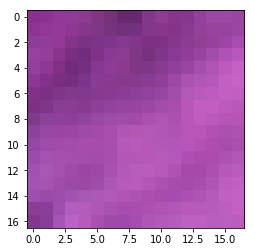

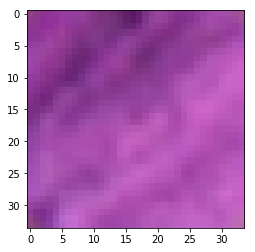

In [105]:
imshow(i1[0])
net.cpu()
result = net(i1.double())
#print(np.transpose(result[0].detach().numpy(), (1, 2, 0)))
res = result[0].detach().numpy()
net.cuda()
plt.imshow(PS(res, r))

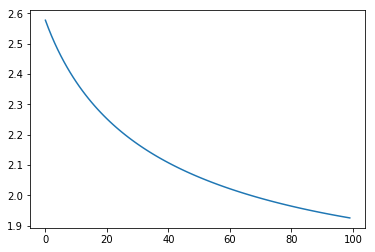

In [79]:
plt.plot(losses)

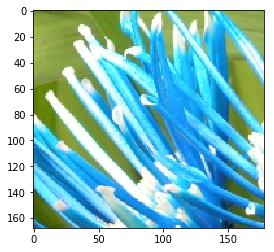

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


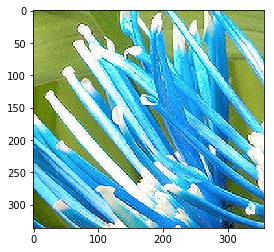

In [128]:
img = plt.imread("datasets/T91/t6.png")
plt.imshow(img)
plt.show()

img = np.transpose(img, (2, 0, 1))
img = torch.Tensor(img).unsqueeze(0).double()
net.cpu()
result = net(img).detach().numpy()
net.cuda()
plt.imshow(PS(result[0], r))